In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LaTeXStrings
using Printf
using LsqFit
using BenchmarkTools
using LinearAlgebra
using StaticArrays

In [2]:

include("../aux_functions.jl")

differentials

In [ ]:
SVector(1,1)

In [ ]:
J = 200
N = 8_000
M_g = 11
L = 200
dx = L/J
order = 5
par_grid = (N, L, J, dx, order)
v = rand(2N+J,M_g);
κ = 2π/L

t_i = 0.0
t_f = 2.0
M = 2001
dt = (t_f - t_i)/(M_g - 1)
par_evolv = (t_i, t_f, M, M_g, dt)

θ = 0.001
nm = 2
par_f = (θ, nm, κ)

In [ ]:
n = zeros(J)
ϕ = zeros(J)
Tn = zeros(J, nthreads())
par_density = (par_grid, Tn)
E_f = zeros(J)
get_density!(v[:,end], n, par_grid)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f,dx)
E_f_t = zeros(J)
get_density_threads!(v[:,end], n, par_density)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f_t,dx)
(E_f - E_f_t)'*(E_f - E_f_t)

In [ ]:
@time Energy_K, Energy_E, EField_T, p_T, Q_T, S_T, T = get_averages(v,par_grid,par_evolv, par_f);


In [ ]:
@time Energy_K_t, Energy_E_t, EField_T_t, p_T_t, Q_T_t, S_T_t, T_t = get_averages_threads(v,par_grid,par_evolv, par_f);

### Testing v2p and p2v



In [ ]:
p = rand(10)
m=2
v = p2v.(p;m=m)
p - v2p.(v;m=m)

In [ ]:
v = p2v.(p)
p - v2p.(v)

In [ ]:
v = [[0.2,0.3],[0.1,0.05]] # it works ok with lists of vectors too.
v2p.(v)

### Testing particles positions and momenta

In [ ]:
include("../aux_functions.jl")

D = 2
x = zeros(D)
p = zeros(D)

@show par_dis = [i for i in 1:4D]



i = 2
get_positions!(x,i,par_dis)

  
get_momenta!(p,i,par_dis)

@show x, p

## Testing index and y functions

In [ ]:
J=1000
L=100
s = 28.74
get_index_and_y(s,J,L)

In [ ]:
Jt = (100, 200, 200)
Box = (0.0, 10, 0.0, 20, -20.0, 0.0)
ss = [8.74, 8.74, -11.26]
j=[1,1,1]
y=zeros(3)
get_index_and_y!(j,y,ss,Jt,Box)

In [ ]:
Jt = (100, 200, 200)
Box = (0.0, 10, 0.0, 20, -20.0, 0.0)
ss = [8.74, 8.74, -11.26]
j=[1,1,1]
y=zeros(3)
r = view(ss,1:3)
get_index_and_y!(j,y,r,Jt,Box)

## Testing Shape Functions

In [ ]:
const cinco = 5
@btime W(5,$0.4)

In [ ]:
v = [0.5,0.5]
@show s = norm(v)

@btime W(5,0.7071067811865476)
@btime W(5,s)

In [ ]:
v = SVector(0.5,0.5)
@btime W(5,v)

In [ ]:
@btime norm([0.5,0.5],2)

In [ ]:
@btime sqrt($(0.5)^2+$(0.5)^2)

In [ ]:
@btime sqrt(v'*v)

In [ ]:
order = 5
x = -4:0.1:4
y = -4:0.1:4


f(order,x) = Shape(order,x[1])*Shape(order,x[2])

default(size=(600,600), fc=:heat)

z = Surface((x,y)->f(order,[x,y]), x, y)
surface(x,y,z, linealpha = 0.3)



## Density test

In [ ]:
N = 1
J = 20
L = 10
order = 5
par_grid = (N, L, J, L/J, order)
n = zeros(20)
u = [3.0]
get_density!(u,n,par_grid,0)
x = 0:L/J:(L-L/J)
plot(x,n)
scatter!(x,n)
#sum(n)/J

In [ ]:
N = 1
J = 20
L = 10
order = 5
par_grid = (N, L, J, L/J, order)
n = zeros(20)
u = [5.1]
get_density!(u,n,par_grid,0.5)
x = 0:L/J:(L-L/J)
plot(x,n)
scatter!(x,n)
#sum(n)/J

In [14]:
include("../aux_functions.jl")
const N = 2_000
const J = (100,200)
const Box = (0.0,1.0,0.0,1.0)
const order = 5
const par_grid = (N, Box, J, order)
n1 = zeros(J)
u = rand(4*N)
j = [0,0]
y = [0.0,0.0]
#@show r = view(u,1:2)
#@show get_index_and_y!(j,y,r,J,Box)
#@show j, y

#@btime get_density_2D!($u,$n1,$par_grid,$0)
get_density_2D!(u,n1,par_grid,0)
#plot_matrix(n)
#sum(n)

100×200 Matrix{Float64}:
 2.12283e-6   2.88716e-5   0.000140283  …  0.000172783  6.27305e-5
 2.08566e-7   3.20579e-6   3.24212e-5      3.60802e-5   1.27672e-5
 2.82648e-6   2.13052e-5   5.84948e-5      1.14299e-7   4.10693e-8
 2.05343e-5   0.000151546  0.000129282     1.20562e-13  1.16999e-7
 9.00503e-5   0.000257286  0.000204708     3.27969e-7   6.88054e-6
 0.000266999  0.00035919   0.000167835  …  8.77596e-6   3.11026e-5
 0.000200278  0.000222974  0.000180356     2.92924e-5   0.000121592
 9.88022e-5   6.04676e-5   9.36372e-5      3.21294e-5   0.000137815
 3.3153e-5    2.72553e-6   3.82141e-6      6.72322e-5   0.000111269
 3.8663e-5    2.14789e-7   2.52492e-9      8.10927e-5   0.000164097
 ⋮                                      ⋱               
 5.518e-5     1.13628e-6   1.31139e-5      0.000121036  0.000222677
 1.38187e-5   1.3572e-6    7.08041e-5      6.61836e-5   9.0694e-5
 2.18616e-5   2.2938e-6    4.67972e-5      8.9131e-6    2.86019e-5
 0.000121818  1.10969e-5   7.56308e-6      

In [4]:
include("../aux_functions.jl")
#const N = 2_000_000
#const N = 2_0
#const J = (200,100)
#const Box = (0.0,1.0,0.0,1.0)
#const order = 5
#const par_grid = (N, Box, J, order)

#u = rand(4*N)
u_r = [0.501,0.403]
n2 = zeros(J)
Tn = zeros(J...,nthreads())
j = fill([1,1],nthreads()) 
y = fill([1.0,1.0],nthreads())

get_index_and_y!(j[1], y[1], u_r, J, Box)
@show y[2]
#@show j[1]

y[2] = [0.09999999999999432, 0.6000000000000227]


2-element Vector{Float64}:
 0.09999999999999432
 0.6000000000000227

In [11]:
include("../aux_functions.jl")
#@btime get_density_threads_2D!($u,$n2,$(par_grid,Tn),$0)
get_density_threads_2D!(u,n2,(par_grid,Tn),0)

100×200 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [12]:
@show sum(n1) sum(n2) norm(n1-n2)

sum(n1) = 1.0
sum(n2) = 1.0
norm(n1 - n2) = 0.04208072479582461


0.04208072479582461

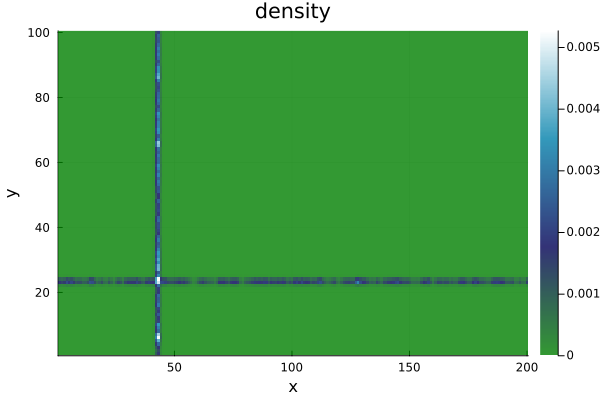

In [16]:
heatmap(n2,
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        #yflip = true,
        xlabel = "x", ylabel = "y",
        title = "density"
    )

In [ ]:
N = 2000
J = (20,30)
Box = (0.0,10.0,0.0,20.0)
order = 5
par_grid = (N, Box, J, order)
n = zeros(J[1],J[2])
u = rand(4N)*10
#u = [3.1,3.2,0.0,0.0,6.4,7.5,0.0,0.0]
j = [0,0]
y = [0.0,0.0]

get_density_2D!(u,n,par_grid,0);

In [ ]:
heatmap(n',
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        #yflip = true,
        xlabel = "x", ylabel = "y",
        title = "density"
    )

## Test Volume and differentials




In [ ]:

Box = (0.0,10, 0.0, 20, -10.0, 10)
J = (100,100,200)

@show volume(Box)
@show differentials(Box,J)

### Test make_periodic function (OK)

In [ ]:
include("../aux_functions.jl")
r = [2.,6.1,4.,5.,6.3,7.2,8.,9.2]
Box = (1.,2.2,3.,5.)
make_periodic!(r,Box)

In [ ]:
r

In [ ]:
A = [[0,0] for i in 1:10, j in 1:8]

In [ ]:
A[1,2]

## Test Poisson equation

In [ ]:
include("../aux_functions.jl")
J = (100,100)
Box = (0,1,0,2)
ϕ = zeros(J)

n = [0.1*i*j for i in 1:J[1], j in 1:J[2]]

get_ϕ_D!(ϕ, n, Box)


## Field tests

In [ ]:
N = 5
D=2
par_dis = [2D*N]
J = (12,8)

E = [[i,j] for i in 1:J[1], j in 1:J[2] ]
B = [ i*j for i in 1:J[1], j in 1:J[2] ]

E
#E[1,2]
#getindex.(E,1)


In [ ]:
Me = J[1]*J[2]
EL = zeros(2Me)
for i in 1:J[1]
    for j in 1:J[2]
        l = 2*(j-1)*J[1] + 2*i -1
            EL[l] = E[i,j][1]
            EL[l+1] = E[i,j][2]
    end
end
EL
#E_v = reshape(EL,D,J[2],J[1])
#E_v[1,:,:]

In [ ]:
Em = reshape(EL,D,J[1]*J[2])'
Emm = reshape(Em,(J...,D))

In [ ]:
getindex.(E,2) - Emm[:,:,2]

In [ ]:
Emm[2,3,:]

In [ ]:
reshape(EE,2,100,100)[1,:,:] - 5*reshape(EE,2,100,100)[2,:,:]

8.361 μs (2 allocations: 96 bytes) (i,j)

7.730 μs (2 allocations: 96 bytes) (j,i)

18.307 μs (6 allocations: 156.44 KiB) (sin los for)